In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob 
import os
os.chdir("train/face/")

In [2]:
import numpy as np
import copy
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor
import ot
import torch
import sklearn 
from sklearn import datasets
import matplotlib.pyplot as plt
import scipy
from scipy.io import loadmat
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64

PLT_CELL = 2.5
figs_path = "/home/zsteve/wtf/manuscript/figs/"

In [3]:
import sys
sys.path.insert(0, "/home/zsteve/wtf/src")
import wtf

In [4]:
X = []
for f in glob.glob("*.pgm"):
    X += [wtf.normalise(np.array(Image.open(f))), ]

In [5]:
X = torch.Tensor(np.stack(X))

In [6]:
X = X[0:500, :, :]

In [7]:
def outer(u, v):
    return u.reshape(-1, 1) * v.reshape(1, -1)

In [8]:
sizex, sizey = (19, 19)
xx, yy = np.meshgrid(range(sizex), range(sizey))
coords = np.vstack((xx.reshape(1, sizex*sizey), yy.reshape(1, sizex*sizey))).T
C_full = ot.utils.euclidean_distances(coords, coords, squared=True)
C_full = torch.Tensor(C_full/C_full.mean()).to(device)

In [50]:
# now pick multilinear rank
d = 3
r = [50, ]*3
S = tl.zeros(r).to(device)
for i in range(r[0]):
    S[i, i, i] = 1

# initialise using SVD components as done by non_negative_parafac, hence n_iter_max = 0
factor_cp = tl.decomposition.non_negative_parafac(X, rank = r[0], n_iter_max = 0, init = "svd")
A = copy.deepcopy(factor_cp.factors)
A = [a.to(device) for a in A]
X0 = X.to(device)

In [75]:
n_iter = 25
r0 = 0.01
lr = np.array([[1, 1, 1], ]*n_iter)*1
lamda = np.array([np.ones(3), ]*n_iter)*50
optim_modes = [0, ]
rho = np.array([np.ones(3), ]*n_iter)*r0/r[0]
eps = np.ones((n_iter, 3))*0.005

In [76]:
A[0] = (A[0].T/A[0].sum(1)).T
A[1] = A[1]/A[1].sum(0)
A[2] = A[2]/A[2].sum(0)

In [77]:
dual_objs = [[], [], [], ]

max_iter, print_inter, check_iter, unbal = (100, 10, 10, False) 
tol = 1e-4
mode = "lbfgs"
for i in range(n_iter):
    print("Block iteration ", i)
    print("Mode 0")
    m0 = wtf.FactorsModel(X0, 0, [C_full, ], S, A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "row")
    dual_objs[0] += [wtf.solve(m0, lr = lr[i, 0], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0, 1, [C_full, ], S, A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "col")
    dual_objs[1] += [wtf.solve(m1, lr = lr[i, 1], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[1] = m1.compute_primal_variable().detach()
    print("Mode 2") 
    m2 = wtf.FactorsModel(X0, 2, [C_full, ], S, A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "col")
    dual_objs[2] += [wtf.solve(m2, lr = lr[i, 2], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[2] = m2.compute_primal_variable().detach()

Block iteration  0
Mode 0
i = 0 	 dual = 18.919261
i = 10 	 dual = 18.913824
Mode 1
i = 0 	 dual = 18.602202
i = 10 	 dual = 18.576534
i = 20 	 dual = 18.575986
Mode 2
i = 0 	 dual = 18.600931
i = 10 	 dual = 18.577403
i = 20 	 dual = 18.576942
Block iteration  1
Mode 0
i = 0 	 dual = 18.920124
i = 10 	 dual = 18.914761
Mode 1
i = 0 	 dual = 18.602173
i = 10 	 dual = 18.576885
i = 20 	 dual = 18.576347
Mode 2
i = 0 	 dual = 18.600928
i = 10 	 dual = 18.577727
i = 20 	 dual = 18.577309
Block iteration  2
Mode 0
i = 0 	 dual = 18.920261
i = 10 	 dual = 18.915662
Mode 1
i = 0 	 dual = 18.602134
i = 10 	 dual = 18.577225
i = 20 	 dual = 18.576723
Mode 2
i = 0 	 dual = 18.600921
i = 10 	 dual = 18.578114
i = 20 	 dual = 18.577708
Block iteration  3
Mode 0
i = 0 	 dual = 18.921026
i = 10 	 dual = 18.916555
Mode 1
i = 0 	 dual = 18.602054
i = 10 	 dual = 18.577582
i = 20 	 dual = 18.577094
Mode 2
i = 0 	 dual = 18.600981
i = 10 	 dual = 18.578395
i = 20 	 dual = 18.577984
Block iteration  4
M

In [78]:
X_hat = tl.tenalg.multi_mode_dot(S, A).cpu()
factor_cp = tl.decomposition.non_negative_parafac(X, rank = r[0], init = "svd", n_iter_max = 1000)
X_cp = tl.cp_tensor.cp_to_tensor(factor_cp)

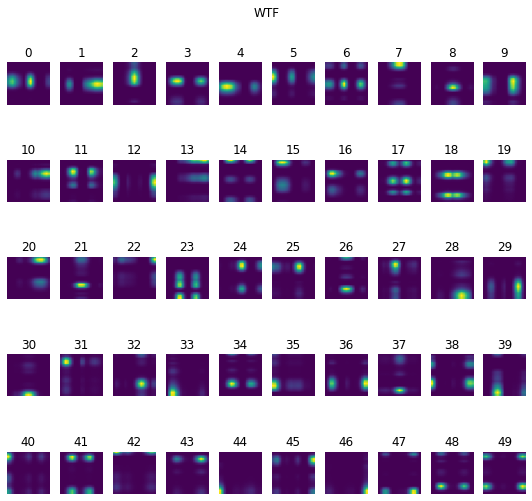

In [79]:
plt.figure(figsize = (3*PLT_CELL, 3*PLT_CELL))
plt.suptitle("WTF")
perm = np.array(np.argsort(A[0].sum(0).cpu()))[::-1]
for i in range(50): 
    plt.subplot(5, 10, i+1)
    plt.title("%d" % i)
    plt.imshow(outer(A[1][:, perm[i]], A[2][:, perm[i]]).cpu())
    plt.axis("off")
plt.tight_layout()

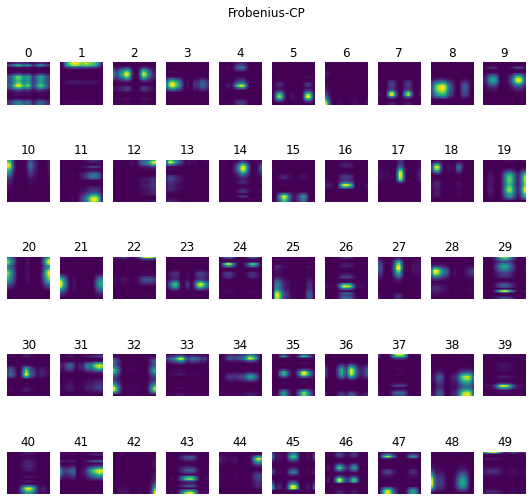

In [80]:
plt.figure(figsize = (3*PLT_CELL, 3*PLT_CELL))
plt.suptitle("Frobenius-CP")
perm = np.array(np.argsort(factor_cp.factors[0].sum(0)))[::-1]
for i in range(50): 
    plt.subplot(5, 10, i+1)
    plt.title("%d" % i)
    plt.imshow(outer(factor_cp.factors[1][:, perm[i]], factor_cp.factors[2][:, perm[i]]).cpu())
    plt.axis("off")
plt.tight_layout()

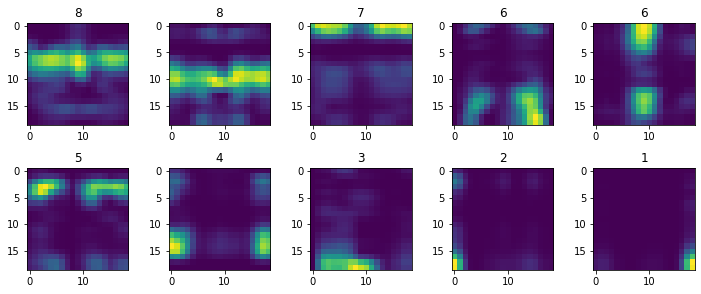

In [81]:
from sklearn import cluster
n_clust = 10
d = np.stack([np.kron(A[1][:, i].cpu(), A[2][:, i].cpu()) for i in range(r[0])])
basis_clust = sklearn.cluster.SpectralClustering(n_clusters = n_clust, gamma = 1, n_init = 100)
clust = basis_clust.fit_predict(d)

perm = np.argsort([sum(clust == k) for k in range(n_clust)])[::-1]

plt.figure(figsize = (10, 10))
for k in range(n_clust):
    plt.subplot(5, 5, k+1)
    plt.imshow(sum([outer(A[1][:, i], A[2][:, i]) for i in np.where(clust == perm[k])[0]]).cpu())
    plt.title(sum(clust == perm[k]))
plt.tight_layout()

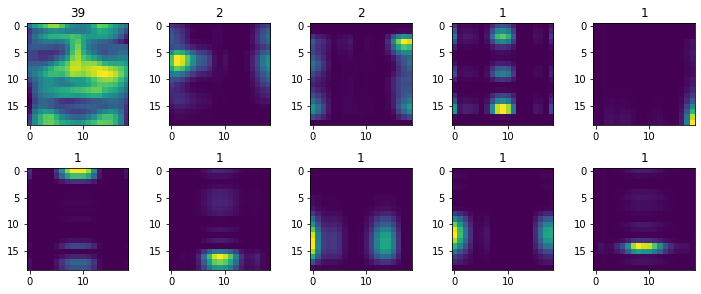

In [82]:
from sklearn import cluster
n_clust = 10
d = np.stack([np.kron(factor_cp.factors[1][:, i], factor_cp.factors[2][:, i]) for i in range(r[0])])
basis_clust = sklearn.cluster.SpectralClustering(n_clusters = n_clust, gamma = 0.25)
clust = basis_clust.fit_predict(d)

perm = np.argsort([sum(clust == k) for k in range(n_clust)])[::-1]

plt.figure(figsize = (10, 10))
for k in range(n_clust):
    plt.subplot(5, 5, k+1)
    plt.imshow(sum([outer(factor_cp.factors[1][:, i], factor_cp.factors[2][:, i]) for i in np.where(clust == perm[k])[0]]))
    plt.title(sum(clust == perm[k]))
plt.tight_layout()

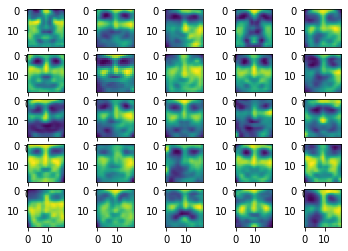

In [83]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_hat[i, :, :])

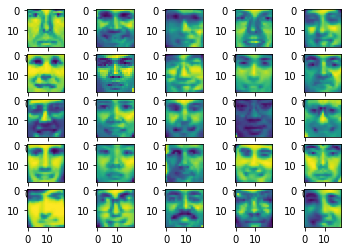

In [84]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i, :, :])

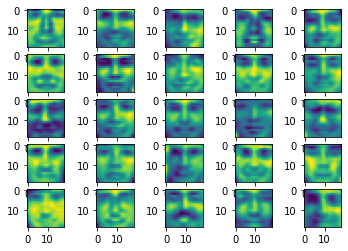

In [85]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_cp[i, :, :])